# 3.4 차원 축소, 특성 추출, 매니폴드 학습

1. 비음수 행렬 분해
2. 2차원 산점도를 이용해 시각화 용도로 많이 사용하는 t-SNE 알고리즘

## 3.4.1 주성분 분석(PCA)

In [1]:
import mglearn
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager
import matplotlib
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
print(font_family)

Malgun Gothic


In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/malgun.ttf'

font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family

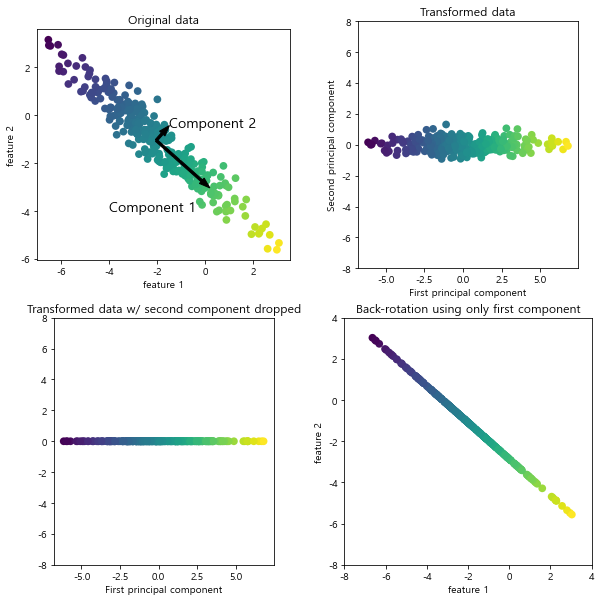

In [4]:
mglearn.plots.plot_pca_illustration()

### PCA를 적용해 유방암 데이터셋 시각화하기

PCA가 가장 널리 사용되는 분야는 고차원 데이터셋의 시각화입니다.

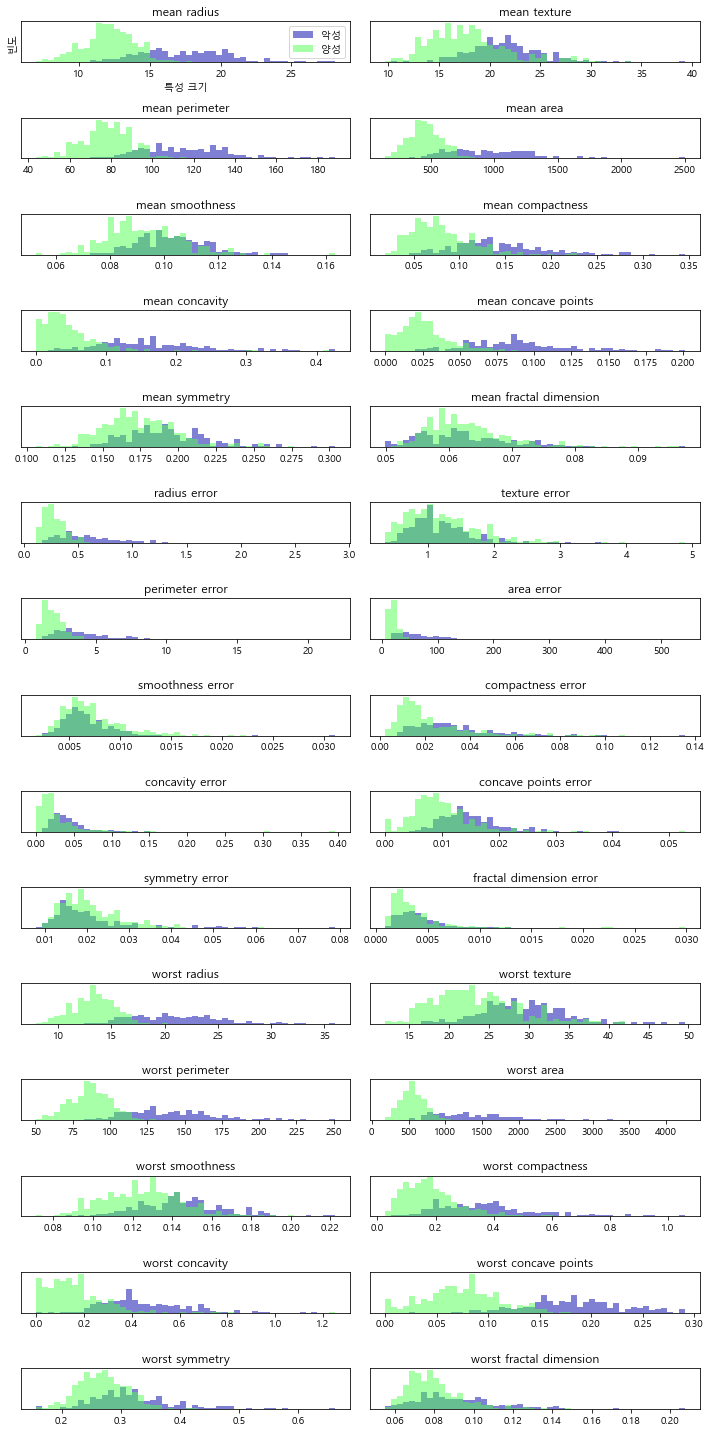

In [5]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)    
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("특성 크기")
ax[0].set_ylabel("빈도")
ax[0].legend(["악성", "양성"], loc="best")
fig.tight_layout()

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [7]:
from sklearn.decomposition import PCA
# 데이터의 처음 두 개 주성분만 유지시킵니다.
pca = PCA(n_components=2)
# 유방암 데이터로 PCA 모델을 만듭니다.
pca.fit(X_scaled)

# 처음 두 개의 주성분을 사용해 데이터를 변환합니다.
X_pca = pca.transform(X_scaled)
print("원본 데이터 형태:", str(X_scaled.shape))
print("축소된 데이터 형태:", str(X_pca.shape))

원본 데이터 형태: (569, 30)
축소된 데이터 형태: (569, 2)


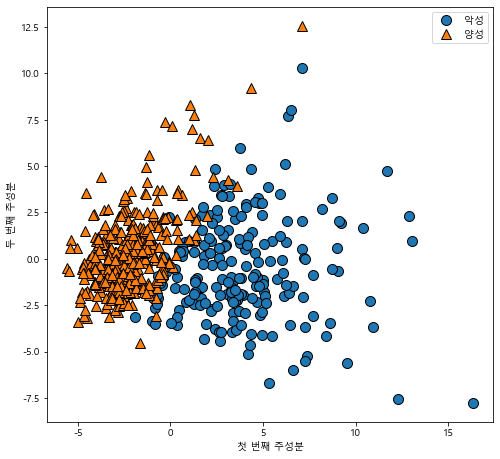

In [8]:
# 클래스를 색깔로 구분하여 처음 두 개의 주성분을 그래프로 나타냅니다.
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(["악성", "양성"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")
plt.show()

PCA의 단점은 그래프의 두 축을 해석하기가 쉽지 않다는 점.

In [9]:
print("PCA 주성분 형태:", pca.components_.shape)

PCA 주성분 형태: (2, 30)


In [10]:
print("PCA 주성분:\n", pca.components_)

PCA 주성분:
 [[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, '주성분')

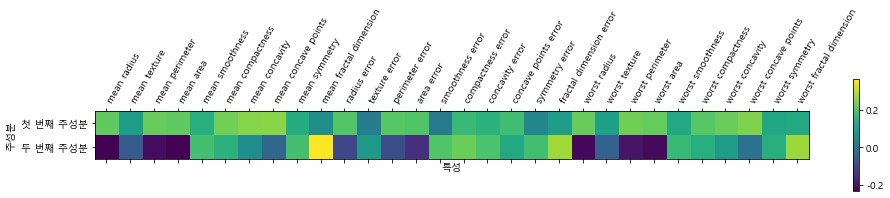

In [11]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["첫 번째 주성분", "두 번째 주성분"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("특성")
plt.ylabel("주성분")

### 고유 얼굴(eigenface)특성 추출

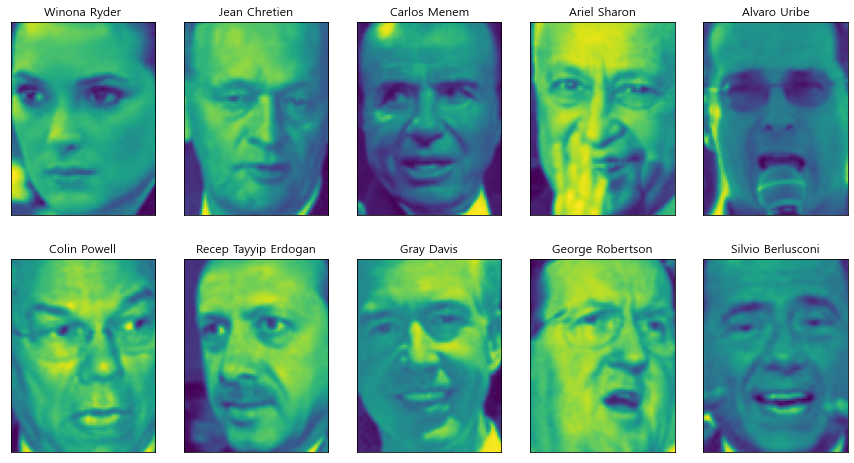

In [12]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks' : (), 'yticks' : ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [13]:
print("people.images.shape :", people.images.shape)
print("클래스 개수 :", len(people.target_names))

people.images.shape : (3023, 87, 65)
클래스 개수 : 62


In [14]:
# 각 타깃이 나타난 횟수 계산
counts = np.bincount(people.target)
# 타깃별 이름과 횟수 출력
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [15]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0~255사이의 흑백 이미지의 픽셀 값을 0~1 스케일로 조정합니다.
X_people = X_people / 255.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
# 이웃 개수를 한 개로 하여 KneighborsCalssfier 모델을 만듭니다.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("1-최근접 이웃의 테스트 세트 점수 : {:.2f}".format(knn.score(X_test, y_test)))

1-최근접 이웃의 테스트 세트 점수 : 0.23


점수가 아주 낮게 나오므로 PCA의 화이트닝 옵션을 사용하여 정확도 측정

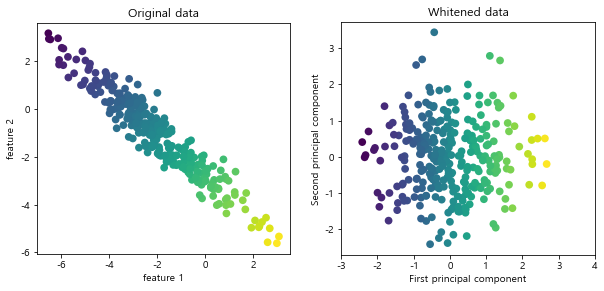

In [17]:
mglearn.plots.plot_pca_whitening()

In [18]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape :", X_train_pca.shape)

X_train_pca.shape : (1547, 100)


In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("1-최근접 이웃의 테스트 세트 점수 : {:.2f}".format(knn.score(X_test_pca, y_test)))

1-최근접 이웃의 테스트 세트 점수 : 0.31


주성분을 확인해보자

In [20]:
print("pca.components_.shape", pca.components_.shape)

pca.components_.shape (100, 5655)


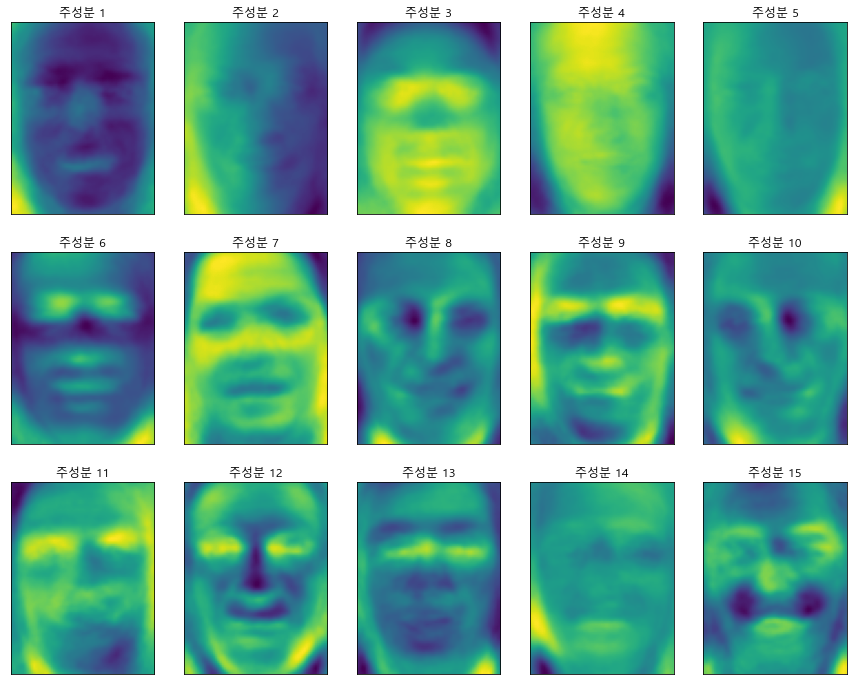

In [21]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks' : (), 'yticks' : ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("주성분 {}".format((i + 1)))

주성분 개수에 따른 세 얼굴 이미지의 재구성을 해보겠습니다.

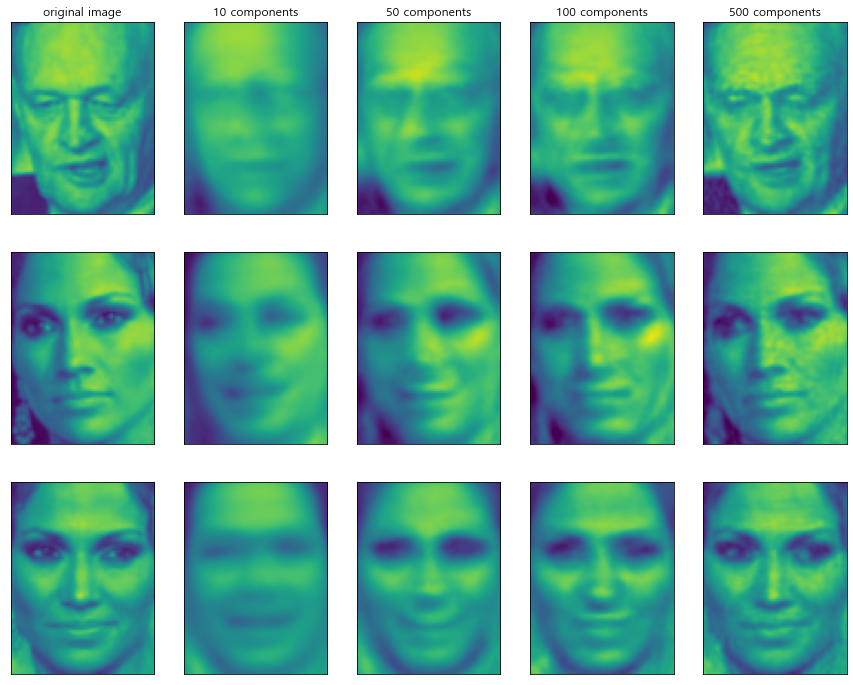

In [22]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

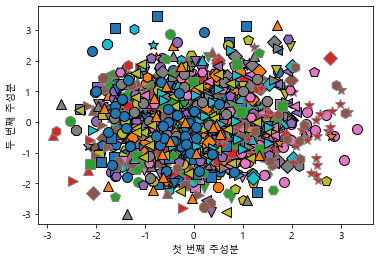

In [23]:
# 산점도로 나타내기
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")
plt.show()

## 3.4.2 비음수 행렬 분해(NMF)

NMF(non-nagative matrix factorization)는 유용한 특성을 뽑아내기 위한 또 다른 비지도 학습 알고리즘입니다. 

PCA - 데이터의 분산이 가장 크고 수직인 성분을 찾는다
NMF - 음수가 아닌 성분과 계수값을 찾는다 => 0보다 크거나 같아야함

NMF는 오디오 트랙이나 음악같은 소스가 추가되어있는 데이터에 유용하다.

### 인위적 데이터에 NMF 적용하기

우선 데이터가 양수인지 확인해야한다.

C:\Users\d\anaconda3\envs\tensorflow2_env\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\d\anaconda3\envs\tensorflow2_env\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


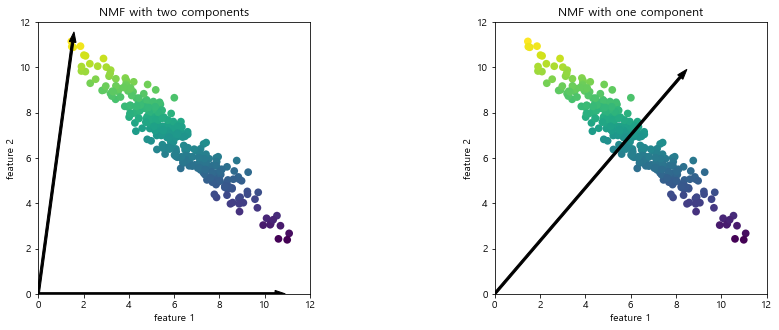

In [24]:
mglearn.plots.plot_nmf_illustration()

### 얼굴 이미지에 NMF 적용하기

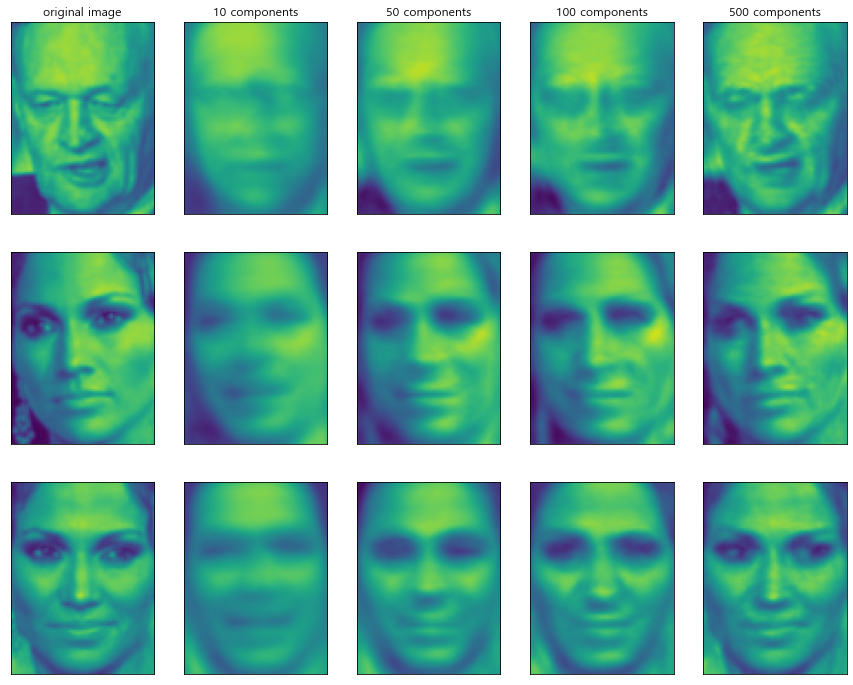

In [25]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

C:\Users\d\anaconda3\envs\tensorflow2_env\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


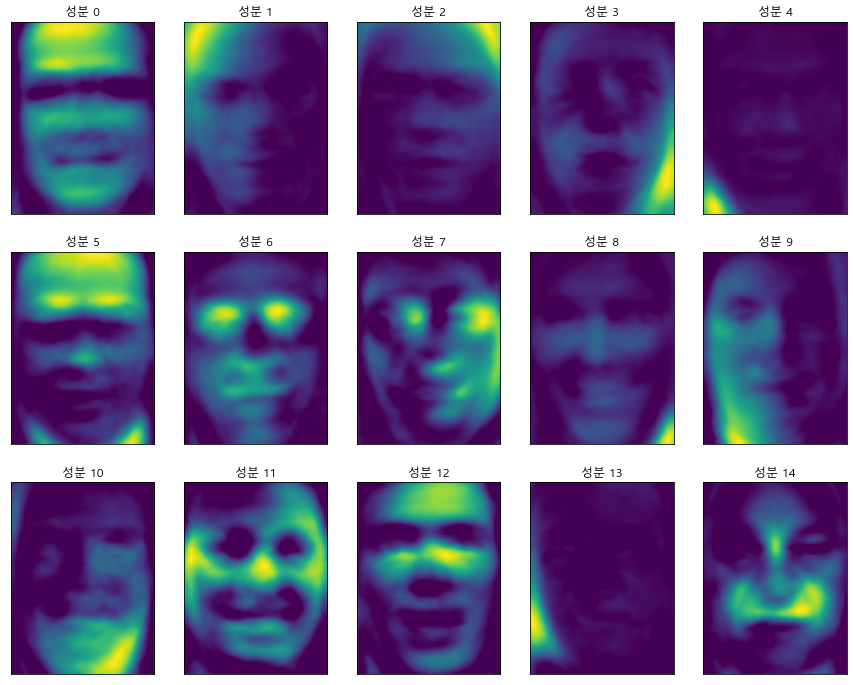

In [30]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks':(), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("성분 {}".format(i))